In [1]:
# import scipy.io as sio
# import matplotlib.pyplot as plt
# from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sleepdetector_claude import Sleepdetector
# from tqdm import tqdm

# # Load Data File
# filepath = '../data/data.mat'
# mat_file = sio.loadmat(filepath)
# x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=0)

# # Convert numpy array to PyTorch tensor
# x = torch.from_numpy(x).float()

# # Load actual labels
# labels_file = '../data/labels.mat'
# y_true = sio.loadmat(labels_file)['labels'].flatten() - 1  # Subtract 1 to match 0-4 encoding
# y = torch.from_numpy(y_true).long()

# print(f"Shape of x: {x.shape}")
# print(f"Shape of y: {y.shape}")

# # Ensure x and y have matching dimensions
# assert x.shape[1] == y.shape[0], f"Mismatch in number of examples: x has {x.shape[1]}, y has {y.shape[0]}"

# #

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sleepdetector_improved import ImprovedSleepdetector
from tqdm import tqdm
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load Data File
filepath = '../data/data.mat'
mat_file = sio.loadmat(filepath)
x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=0)

# Convert numpy array to PyTorch tensor
x = torch.from_numpy(x).float()

# Load actual labels
labels_file = '../data/labels.mat'
y_true = sio.loadmat(labels_file)['labels'].flatten() - 1  # Subtract 1 to match 0-4 encoding
y = torch.from_numpy(y_true).long()

print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")



Shape of x: torch.Size([4, 1027, 3000, 1])
Shape of y: torch.Size([1027])


In [3]:
# Reshape x to match the expected input shape of the model
x = x.permute(1, 0, 2, 3)  # Change from [4, 1027, 3000, 1] to [1027, 4, 3000, 1]

# Split the data into train and test sets
train_size = int(0.8 * len(x))
test_size = len(x) - train_size

X_train, X_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
model = ImprovedSleepdetector()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    kappa = cohen_kappa_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    conf_matrix = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Cohen\'s Kappa: {kappa:.4f}')



Epoch 1/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:   4%|▍         | 1/26 [00:02<01:08,  2.73s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:   8%|▊         | 2/26 [00:05<01:00,  2.52s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  12%|█▏        | 3/26 [00:07<00:56,  2.45s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  15%|█▌        | 4/26 [00:09<00:52,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  19%|█▉        | 5/26 [00:12<00:49,  2.35s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  23%|██▎       | 6/26 [00:14<00:46,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  27%|██▋       | 7/26 [00:16<00:45,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  31%|███       | 8/26 [00:19<00:43,  2.44s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  35%|███▍      | 9/26 [00:21<00:41,  2.46s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  38%|███▊      | 10/26 [00:24<00:39,  2.49s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  42%|████▏     | 11/26 [00:26<00:36,  2.44s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  46%|████▌     | 12/26 [00:29<00:33,  2.40s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  50%|█████     | 13/26 [00:31<00:30,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  54%|█████▍    | 14/26 [00:33<00:27,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  58%|█████▊    | 15/26 [00:35<00:24,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  62%|██████▏   | 16/26 [00:37<00:22,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  65%|██████▌   | 17/26 [00:39<00:19,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  69%|██████▉   | 18/26 [00:42<00:17,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  73%|███████▎  | 19/26 [00:44<00:15,  2.28s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  77%|███████▋  | 20/26 [00:47<00:14,  2.41s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  81%|████████  | 21/26 [00:49<00:12,  2.40s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  85%|████████▍ | 22/26 [00:52<00:09,  2.41s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  88%|████████▊ | 23/26 [00:54<00:07,  2.45s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  92%|█████████▏| 24/26 [00:56<00:04,  2.39s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 1/10:  96%|█████████▌| 25/26 [00:59<00:02,  2.38s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 1/10: 100%|██████████| 26/26 [01:00<00:00,  2.34s/it]


Epoch [1/10], Loss: 1.4642, Accuracy: 33.01%


Epoch 2/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:   4%|▍         | 1/26 [00:02<00:56,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:   8%|▊         | 2/26 [00:04<00:53,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  12%|█▏        | 3/26 [00:06<00:51,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  15%|█▌        | 4/26 [00:09<00:51,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  19%|█▉        | 5/26 [00:11<00:50,  2.38s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  23%|██▎       | 6/26 [00:14<00:48,  2.43s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  27%|██▋       | 7/26 [00:16<00:45,  2.40s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  31%|███       | 8/26 [00:18<00:42,  2.36s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  35%|███▍      | 9/26 [00:21<00:39,  2.34s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  38%|███▊      | 10/26 [00:23<00:37,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  42%|████▏     | 11/26 [00:25<00:34,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  46%|████▌     | 12/26 [00:27<00:32,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  50%|█████     | 13/26 [00:30<00:30,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  54%|█████▍    | 14/26 [00:32<00:27,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  58%|█████▊    | 15/26 [00:34<00:25,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  62%|██████▏   | 16/26 [00:37<00:23,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  65%|██████▌   | 17/26 [00:39<00:20,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  69%|██████▉   | 18/26 [00:41<00:18,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  73%|███████▎  | 19/26 [00:44<00:16,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  77%|███████▋  | 20/26 [00:47<00:14,  2.48s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  81%|████████  | 21/26 [00:49<00:12,  2.47s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  85%|████████▍ | 22/26 [00:53<00:11,  2.84s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  88%|████████▊ | 23/26 [00:55<00:08,  2.71s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  92%|█████████▏| 24/26 [00:58<00:05,  2.63s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 2/10:  96%|█████████▌| 25/26 [01:00<00:02,  2.60s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 2/10: 100%|██████████| 26/26 [01:02<00:00,  2.41s/it]


Epoch [2/10], Loss: 1.2295, Accuracy: 48.72%


Epoch 3/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:   4%|▍         | 1/26 [00:02<00:59,  2.39s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:   8%|▊         | 2/26 [00:04<00:56,  2.35s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  12%|█▏        | 3/26 [00:07<00:56,  2.47s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  15%|█▌        | 4/26 [00:09<00:53,  2.44s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  19%|█▉        | 5/26 [00:12<00:53,  2.53s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  23%|██▎       | 6/26 [00:14<00:50,  2.52s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  27%|██▋       | 7/26 [00:17<00:48,  2.56s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  31%|███       | 8/26 [00:20<00:46,  2.58s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  35%|███▍      | 9/26 [00:22<00:42,  2.52s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  38%|███▊      | 10/26 [00:24<00:38,  2.43s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  42%|████▏     | 11/26 [00:27<00:35,  2.39s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  46%|████▌     | 12/26 [00:31<00:40,  2.90s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  50%|█████     | 13/26 [00:34<00:37,  2.90s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  54%|█████▍    | 14/26 [00:36<00:32,  2.74s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  58%|█████▊    | 15/26 [00:38<00:29,  2.66s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  62%|██████▏   | 16/26 [00:41<00:25,  2.58s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  65%|██████▌   | 17/26 [00:43<00:23,  2.60s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  69%|██████▉   | 18/26 [00:46<00:20,  2.50s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  73%|███████▎  | 19/26 [00:48<00:16,  2.41s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  77%|███████▋  | 20/26 [00:50<00:14,  2.35s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  81%|████████  | 21/26 [00:52<00:11,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  85%|████████▍ | 22/26 [00:55<00:09,  2.28s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  88%|████████▊ | 23/26 [00:57<00:06,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  92%|█████████▏| 24/26 [00:59<00:04,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 3/10:  96%|█████████▌| 25/26 [01:01<00:02,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 3/10: 100%|██████████| 26/26 [01:03<00:00,  2.43s/it]


Epoch [3/10], Loss: 1.1376, Accuracy: 53.59%


Epoch 4/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:   4%|▍         | 1/26 [00:02<00:54,  2.17s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:   8%|▊         | 2/26 [00:04<00:52,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  12%|█▏        | 3/26 [00:06<00:50,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  15%|█▌        | 4/26 [00:08<00:47,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  19%|█▉        | 5/26 [00:11<00:49,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  23%|██▎       | 6/26 [00:13<00:48,  2.43s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  27%|██▋       | 7/26 [00:16<00:44,  2.36s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  31%|███       | 8/26 [00:18<00:41,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  35%|███▍      | 9/26 [00:20<00:38,  2.29s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  38%|███▊      | 10/26 [00:22<00:35,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  42%|████▏     | 11/26 [00:25<00:33,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  46%|████▌     | 12/26 [00:27<00:31,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  50%|█████     | 13/26 [00:29<00:29,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  54%|█████▍    | 14/26 [00:31<00:26,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  58%|█████▊    | 15/26 [00:33<00:24,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  62%|██████▏   | 16/26 [00:36<00:22,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  65%|██████▌   | 17/26 [00:38<00:20,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  69%|██████▉   | 18/26 [00:41<00:18,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  73%|███████▎  | 19/26 [00:43<00:16,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  77%|███████▋  | 20/26 [00:45<00:13,  2.28s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  81%|████████  | 21/26 [00:47<00:11,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  85%|████████▍ | 22/26 [00:50<00:09,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  88%|████████▊ | 23/26 [00:52<00:06,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  92%|█████████▏| 24/26 [00:54<00:04,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 4/10:  96%|█████████▌| 25/26 [00:56<00:02,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 4/10: 100%|██████████| 26/26 [00:58<00:00,  2.23s/it]


Epoch [4/10], Loss: 1.1369, Accuracy: 51.04%


Epoch 5/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:   4%|▍         | 1/26 [00:02<00:54,  2.16s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:   8%|▊         | 2/26 [00:04<00:51,  2.15s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  12%|█▏        | 3/26 [00:06<00:49,  2.16s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  15%|█▌        | 4/26 [00:08<00:48,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  19%|█▉        | 5/26 [00:10<00:46,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  23%|██▎       | 6/26 [00:13<00:44,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  27%|██▋       | 7/26 [00:15<00:42,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  31%|███       | 8/26 [00:17<00:40,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  35%|███▍      | 9/26 [00:19<00:38,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  38%|███▊      | 10/26 [00:22<00:35,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  42%|████▏     | 11/26 [00:24<00:33,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  46%|████▌     | 12/26 [00:26<00:30,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  50%|█████     | 13/26 [00:28<00:28,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  54%|█████▍    | 14/26 [00:30<00:26,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  58%|█████▊    | 15/26 [00:33<00:24,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  62%|██████▏   | 16/26 [00:35<00:21,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  65%|██████▌   | 17/26 [00:37<00:19,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  69%|██████▉   | 18/26 [00:39<00:17,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  73%|███████▎  | 19/26 [00:42<00:15,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  77%|███████▋  | 20/26 [00:44<00:13,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  81%|████████  | 21/26 [00:46<00:11,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  85%|████████▍ | 22/26 [00:48<00:08,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  88%|████████▊ | 23/26 [00:50<00:06,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  92%|█████████▏| 24/26 [00:52<00:04,  2.17s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 5/10:  96%|█████████▌| 25/26 [00:55<00:02,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 5/10: 100%|██████████| 26/26 [00:56<00:00,  2.18s/it]


Epoch [5/10], Loss: 1.1375, Accuracy: 48.96%


Epoch 6/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:   4%|▍         | 1/26 [00:02<01:00,  2.44s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:   8%|▊         | 2/26 [00:04<00:55,  2.31s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  12%|█▏        | 3/26 [00:06<00:51,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  15%|█▌        | 4/26 [00:09<00:49,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  19%|█▉        | 5/26 [00:11<00:47,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  23%|██▎       | 6/26 [00:13<00:44,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  27%|██▋       | 7/26 [00:15<00:42,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  31%|███       | 8/26 [00:18<00:40,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  35%|███▍      | 9/26 [00:20<00:37,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  38%|███▊      | 10/26 [00:22<00:35,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  42%|████▏     | 11/26 [00:24<00:34,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  46%|████▌     | 12/26 [00:26<00:31,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  50%|█████     | 13/26 [00:29<00:29,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  54%|█████▍    | 14/26 [00:31<00:26,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  58%|█████▊    | 15/26 [00:33<00:24,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  62%|██████▏   | 16/26 [00:35<00:22,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  65%|██████▌   | 17/26 [00:38<00:19,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  69%|██████▉   | 18/26 [00:40<00:17,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  73%|███████▎  | 19/26 [00:42<00:15,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  77%|███████▋  | 20/26 [00:44<00:13,  2.29s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  81%|████████  | 21/26 [00:47<00:11,  2.29s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  85%|████████▍ | 22/26 [00:49<00:08,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  88%|████████▊ | 23/26 [00:51<00:06,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  92%|█████████▏| 24/26 [00:53<00:04,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 6/10:  96%|█████████▌| 25/26 [00:55<00:02,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 6/10: 100%|██████████| 26/26 [00:57<00:00,  2.21s/it]


Epoch [6/10], Loss: 1.0693, Accuracy: 51.64%


Epoch 7/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:   4%|▍         | 1/26 [00:02<00:55,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:   8%|▊         | 2/26 [00:04<00:54,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  12%|█▏        | 3/26 [00:06<00:50,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  15%|█▌        | 4/26 [00:08<00:48,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  19%|█▉        | 5/26 [00:11<00:46,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  23%|██▎       | 6/26 [00:13<00:43,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  27%|██▋       | 7/26 [00:15<00:41,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  31%|███       | 8/26 [00:17<00:39,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  35%|███▍      | 9/26 [00:19<00:37,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  38%|███▊      | 10/26 [00:22<00:35,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  42%|████▏     | 11/26 [00:24<00:33,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  46%|████▌     | 12/26 [00:26<00:30,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  50%|█████     | 13/26 [00:28<00:28,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  54%|█████▍    | 14/26 [00:31<00:26,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  58%|█████▊    | 15/26 [00:33<00:24,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  62%|██████▏   | 16/26 [00:35<00:22,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  65%|██████▌   | 17/26 [00:37<00:19,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  69%|██████▉   | 18/26 [00:39<00:17,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  73%|███████▎  | 19/26 [00:42<00:15,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  77%|███████▋  | 20/26 [00:44<00:13,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  81%|████████  | 21/26 [00:46<00:11,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  85%|████████▍ | 22/26 [00:48<00:09,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  88%|████████▊ | 23/26 [00:51<00:06,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  92%|█████████▏| 24/26 [00:53<00:04,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 7/10:  96%|█████████▌| 25/26 [00:55<00:02,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 7/10: 100%|██████████| 26/26 [00:57<00:00,  2.19s/it]


Epoch [7/10], Loss: 0.9279, Accuracy: 58.34%


Epoch 8/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:   4%|▍         | 1/26 [00:02<00:54,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:   8%|▊         | 2/26 [00:04<00:52,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  12%|█▏        | 3/26 [00:06<00:50,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  15%|█▌        | 4/26 [00:08<00:48,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  19%|█▉        | 5/26 [00:10<00:46,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  23%|██▎       | 6/26 [00:13<00:43,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  27%|██▋       | 7/26 [00:15<00:41,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  31%|███       | 8/26 [00:17<00:39,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  35%|███▍      | 9/26 [00:19<00:37,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  38%|███▊      | 10/26 [00:22<00:36,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  42%|████▏     | 11/26 [00:24<00:33,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  46%|████▌     | 12/26 [00:26<00:31,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  50%|█████     | 13/26 [00:28<00:29,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  54%|█████▍    | 14/26 [00:31<00:26,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  58%|█████▊    | 15/26 [00:33<00:24,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  62%|██████▏   | 16/26 [00:35<00:22,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  65%|██████▌   | 17/26 [00:37<00:20,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  69%|██████▉   | 18/26 [00:39<00:17,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  73%|███████▎  | 19/26 [00:42<00:15,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  77%|███████▋  | 20/26 [00:44<00:13,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  81%|████████  | 21/26 [00:46<00:10,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  85%|████████▍ | 22/26 [00:48<00:08,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  88%|████████▊ | 23/26 [00:50<00:06,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  92%|█████████▏| 24/26 [00:53<00:04,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 8/10:  96%|█████████▌| 25/26 [00:55<00:02,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 8/10: 100%|██████████| 26/26 [00:56<00:00,  2.19s/it]


Epoch [8/10], Loss: 0.9475, Accuracy: 55.54%


Epoch 9/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:   4%|▍         | 1/26 [00:02<00:54,  2.18s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:   8%|▊         | 2/26 [00:04<00:52,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  12%|█▏        | 3/26 [00:06<00:51,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  15%|█▌        | 4/26 [00:08<00:48,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  19%|█▉        | 5/26 [00:11<00:46,  2.20s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  23%|██▎       | 6/26 [00:13<00:44,  2.21s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  27%|██▋       | 7/26 [00:15<00:41,  2.19s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  31%|███       | 8/26 [00:17<00:38,  2.17s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  35%|███▍      | 9/26 [00:19<00:36,  2.17s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  38%|███▊      | 10/26 [00:22<00:36,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  42%|████▏     | 11/26 [00:24<00:35,  2.38s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  46%|████▌     | 12/26 [00:27<00:34,  2.44s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  50%|█████     | 13/26 [00:29<00:31,  2.45s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  54%|█████▍    | 14/26 [00:32<00:28,  2.42s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  58%|█████▊    | 15/26 [00:34<00:26,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  62%|██████▏   | 16/26 [00:36<00:23,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  65%|██████▌   | 17/26 [00:39<00:20,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  69%|██████▉   | 18/26 [00:41<00:18,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  73%|███████▎  | 19/26 [00:43<00:16,  2.37s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  77%|███████▋  | 20/26 [00:46<00:13,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  81%|████████  | 21/26 [00:48<00:11,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  85%|████████▍ | 22/26 [00:50<00:09,  2.28s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  88%|████████▊ | 23/26 [00:52<00:06,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  92%|█████████▏| 24/26 [00:55<00:04,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 9/10:  96%|█████████▌| 25/26 [00:57<00:02,  2.39s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 9/10: 100%|██████████| 26/26 [00:59<00:00,  2.29s/it]


Epoch [9/10], Loss: 0.9481, Accuracy: 56.03%


Epoch 10/10:   0%|          | 0/26 [00:00<?, ?it/s]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:   4%|▍         | 1/26 [00:02<00:56,  2.28s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:   8%|▊         | 2/26 [00:04<00:53,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  12%|█▏        | 3/26 [00:06<00:51,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  15%|█▌        | 4/26 [00:08<00:49,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  19%|█▉        | 5/26 [00:11<00:47,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  23%|██▎       | 6/26 [00:13<00:45,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  27%|██▋       | 7/26 [00:16<00:45,  2.40s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  31%|███       | 8/26 [00:18<00:42,  2.35s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  35%|███▍      | 9/26 [00:20<00:39,  2.33s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  38%|███▊      | 10/26 [00:23<00:37,  2.35s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  42%|████▏     | 11/26 [00:25<00:34,  2.32s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  46%|████▌     | 12/26 [00:27<00:32,  2.30s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  50%|█████     | 13/26 [00:29<00:29,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  54%|█████▍    | 14/26 [00:32<00:27,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  58%|█████▊    | 15/26 [00:34<00:24,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  62%|██████▏   | 16/26 [00:36<00:22,  2.25s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  65%|██████▌   | 17/26 [00:38<00:20,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  69%|██████▉   | 18/26 [00:41<00:17,  2.24s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  73%|███████▎  | 19/26 [00:43<00:15,  2.22s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  77%|███████▋  | 20/26 [00:45<00:13,  2.23s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  81%|████████  | 21/26 [00:47<00:11,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  85%|████████▍ | 22/26 [00:50<00:09,  2.26s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  88%|████████▊ | 23/26 [00:52<00:06,  2.29s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  92%|█████████▏| 24/26 [00:54<00:04,  2.29s/it]

Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])


Epoch 10/10:  96%|█████████▌| 25/26 [00:56<00:02,  2.27s/it]

Input shape to ImprovedSleepdetector: torch.Size([21, 4, 3000, 1])
Shape after squeeze: torch.Size([21, 4, 3000])
Shape after normalization: torch.Size([21, 4, 3000])
Shape of extracted features: torch.Size([21, 1024])
Input shape to CNN: torch.Size([21, 4, 3000])
Shape of x_0: torch.Size([21, 1, 3000])
Shape after conv_blocks[0]: torch.Size([21, 128, 47])
Shape of x_1: torch.Size([21, 1, 3000])
Shape after conv_blocks[1]: torch.Size([21, 128, 47])
Shape of x_2: torch.Size([21, 1, 3000])
Shape after conv_blocks[2]: torch.Size([21, 128, 47])
Shape of x_3: torch.Size([21, 1, 3000])
Shape after conv_blocks[3]: torch.Size([21, 128, 47])
Shape after concatenation: torch.Size([21, 512, 47])
Shape after flatten: torch.Size([21, 24064])
Final output shape: torch.Size([21, 5])
Shape of CNN output: torch.Size([21, 5])
Shape of combined features: torch.Size([21, 1029])
Shape of LSTM input: torch.Size([21, 1, 1029])
Final output shape: torch.Size([21, 5])


Epoch 10/10: 100%|██████████| 26/26 [00:58<00:00,  2.25s/it]


Epoch [10/10], Loss: 0.8518, Accuracy: 59.93%
Input shape to ImprovedSleepdetector: torch.Size([206, 4, 3000, 1])
Shape after squeeze: torch.Size([206, 4, 3000])
Shape after normalization: torch.Size([206, 4, 3000])
Shape of extracted features: torch.Size([206, 1024])
Input shape to CNN: torch.Size([206, 4, 3000])
Shape of x_0: torch.Size([206, 1, 3000])
Shape after conv_blocks[0]: torch.Size([206, 128, 47])
Shape of x_1: torch.Size([206, 1, 3000])
Shape after conv_blocks[1]: torch.Size([206, 128, 47])
Shape of x_2: torch.Size([206, 1, 3000])
Shape after conv_blocks[2]: torch.Size([206, 128, 47])
Shape of x_3: torch.Size([206, 1, 3000])
Shape after conv_blocks[3]: torch.Size([206, 128, 47])
Shape after concatenation: torch.Size([206, 512, 47])
Shape after flatten: torch.Size([206, 24064])
Final output shape: torch.Size([206, 5])
Shape of CNN output: torch.Size([206, 5])
Shape of combined features: torch.Size([206, 1029])
Shape of LSTM input: torch.Size([206, 1, 1029])
Final output shap

In [4]:
# Save the model weights
torch.save(model.state_dict(), 'improved_sleepdetector_weights.pth')


In [5]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    kappa = cohen_kappa_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    conf_matrix = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Cohen\'s Kappa: {kappa:.4f}')

Input shape to ImprovedSleepdetector: torch.Size([206, 4, 3000, 1])
Shape after squeeze: torch.Size([206, 4, 3000])
Shape after normalization: torch.Size([206, 4, 3000])
Shape of extracted features: torch.Size([206, 1024])
Input shape to CNN: torch.Size([206, 4, 3000])
Shape of x_0: torch.Size([206, 1, 3000])
Shape after conv_blocks[0]: torch.Size([206, 128, 47])
Shape of x_1: torch.Size([206, 1, 3000])
Shape after conv_blocks[1]: torch.Size([206, 128, 47])
Shape of x_2: torch.Size([206, 1, 3000])
Shape after conv_blocks[2]: torch.Size([206, 128, 47])
Shape of x_3: torch.Size([206, 1, 3000])
Shape after conv_blocks[3]: torch.Size([206, 128, 47])
Shape after concatenation: torch.Size([206, 512, 47])
Shape after flatten: torch.Size([206, 24064])
Final output shape: torch.Size([206, 5])
Shape of CNN output: torch.Size([206, 5])
Shape of combined features: torch.Size([206, 1029])
Shape of LSTM input: torch.Size([206, 1, 1029])
Final output shape: torch.Size([206, 5])
Test Accuracy: 0.23%
C

Input shape to ImprovedSleepdetector: torch.Size([206, 4, 3000, 1])
Shape after squeeze: torch.Size([206, 4, 3000])
Shape after normalization: torch.Size([206, 4, 3000])
Shape of extracted features: torch.Size([206, 1024])
Input shape to CNN: torch.Size([206, 4, 3000])
Shape of x_0: torch.Size([206, 1, 3000])
Shape after conv_blocks[0]: torch.Size([206, 128, 47])
Shape of x_1: torch.Size([206, 1, 3000])
Shape after conv_blocks[1]: torch.Size([206, 128, 47])
Shape of x_2: torch.Size([206, 1, 3000])
Shape after conv_blocks[2]: torch.Size([206, 128, 47])
Shape of x_3: torch.Size([206, 1, 3000])
Shape after conv_blocks[3]: torch.Size([206, 128, 47])
Shape after concatenation: torch.Size([206, 512, 47])
Shape after flatten: torch.Size([206, 24064])
Final output shape: torch.Size([206, 5])
Shape of CNN output: torch.Size([206, 5])
Shape of combined features: torch.Size([206, 1029])
Shape of LSTM input: torch.Size([206, 1, 1029])
Final output shape: torch.Size([206, 5])
Test Accuracy: 0.23
Co

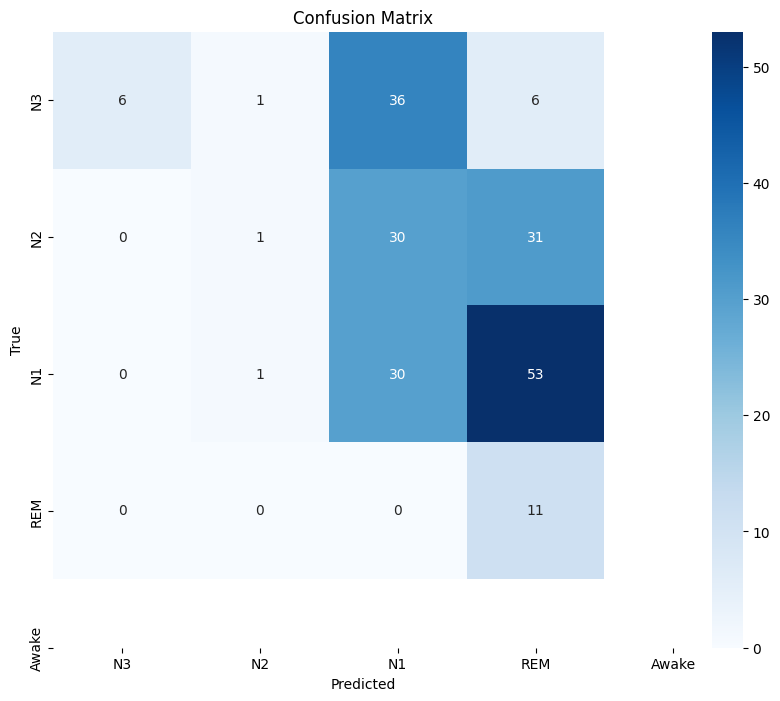

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        _, predicted = torch.max(outputs, 1)
        
        y_true = y_test.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        
        test_accuracy = accuracy_score(y_true, y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        conf_matrix = confusion_matrix(y_true, y_pred)
        
        print(f'Test Accuracy: {test_accuracy:.2f}')
        print(f'Cohen\'s Kappa: {kappa:.4f}')
        
        # Plot confusion matrix
        class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']
        plot_confusion_matrix(conf_matrix, class_names)

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Use the evaluation function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, X_test, y_test, device)


# # Calculate metrics
# accuracy = accuracy_score(true_labels, predictions)
# kappa = cohen_kappa_score(true_labels, predictions)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")

# # Plot confusion matrix
# plot_confusion_matrix(true_labels, predictions)

# # Print classification report
# from sklearn.metrics import classification_report
# class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']
# print(classification_report(true_labels, predictions, target_names=class_names))

In [10]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

train_conf_matrix = confusion_matrix(y_true, y_pred)


Input shape to ImprovedSleepdetector: torch.Size([32, 4, 3000, 1])
Shape after squeeze: torch.Size([32, 4, 3000])
Shape after normalization: torch.Size([32, 4, 3000])
Shape of extracted features: torch.Size([32, 1024])
Input shape to CNN: torch.Size([32, 4, 3000])
Shape of x_0: torch.Size([32, 1, 3000])
Shape after conv_blocks[0]: torch.Size([32, 128, 47])
Shape of x_1: torch.Size([32, 1, 3000])
Shape after conv_blocks[1]: torch.Size([32, 128, 47])
Shape of x_2: torch.Size([32, 1, 3000])
Shape after conv_blocks[2]: torch.Size([32, 128, 47])
Shape of x_3: torch.Size([32, 1, 3000])
Shape after conv_blocks[3]: torch.Size([32, 128, 47])
Shape after concatenation: torch.Size([32, 512, 47])
Shape after flatten: torch.Size([32, 24064])
Final output shape: torch.Size([32, 5])
Shape of CNN output: torch.Size([32, 5])
Shape of combined features: torch.Size([32, 1029])
Shape of LSTM input: torch.Size([32, 1, 1029])
Final output shape: torch.Size([32, 5])
Input shape to ImprovedSleepdetector: torc

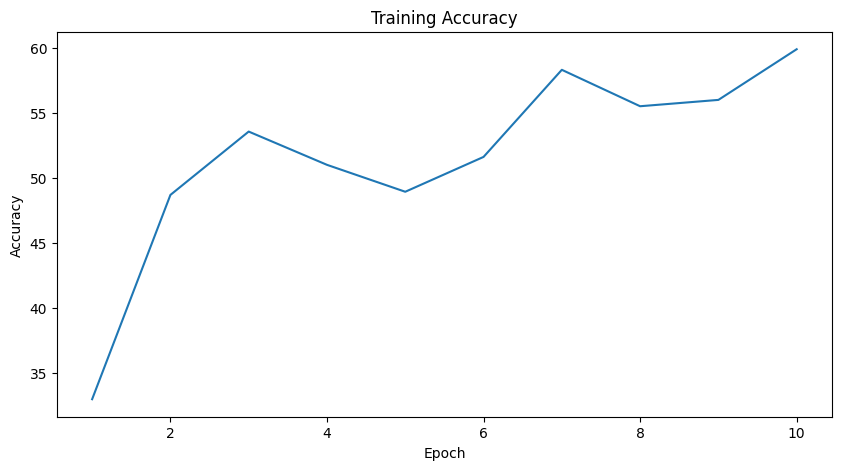

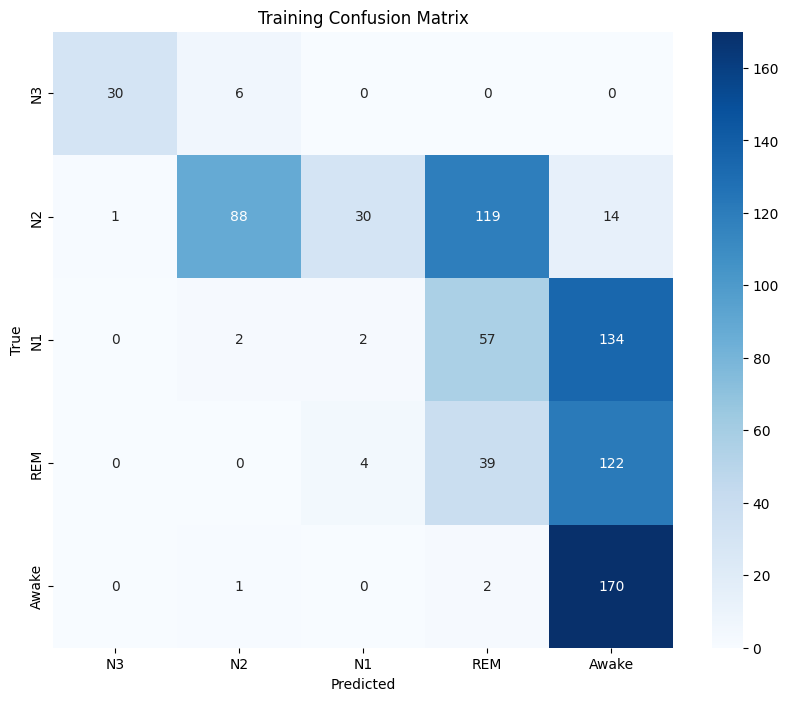

In [11]:
# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot confusion matrix
class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()